# OptOut Project: Construct 14-year-long employment sequences for 14-year-seq sample

In [1]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import defaultdict
from operator import itemgetter
from datetime import datetime, timedelta

# set some nicer defaults for matplotlib
from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

## Retrieve analytic sample

Note: it would have been more convenient if I had first constructed employment sequences for the largest 14-year-seq sample. Note this for future projects. 

In [2]:
# get main 18-year-seq sample
monthly_df_main = pd.read_csv('../data/monthly_df.csv') 
monthly_df_main.head()

,caseid_1979,start_y,start_m,month1,month2,month3,month4,month5,month6,month7,...,month219,month220,month221,month222,month223,month224,month225,month226,month227,month228
0,2,1993,4,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,3,1981,7,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,8,1976,4,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,16,1990,3,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,19,1987,12,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


In [3]:
# cut to 14-year (168 months)
# months in original 18-year-file: 13=180
# months final: 1-168

monthly_df_main = monthly_df_main[['caseid_1979', 'start_y', 'start_m']+['month%i'%i for i in range(13, 181)]]

# rename months
cols = {'month%i'%i:'month%i'%(i-12) for i in range(13, 181)}
monthly_df_main.rename(index=str, columns=cols, inplace=True)
monthly_df_main.head()

,caseid_1979,start_y,start_m,month1,month2,month3,month4,month5,month6,month7,...,month159,month160,month161,month162,month163,month164,month165,month166,month167,month168
0,2,1993,4,8,1,6,6,6,6,6,...,3,3,3,3,3,3,3,3,3,3
1,3,1981,7,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
2,8,1976,4,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,16,1990,3,1,1,8,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,19,1987,12,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


In [4]:
analytic_df = pd.read_csv('../data/analytic_df_seq14.csv') #includes fertility data
print analytic_df.shape

# for the following sections, only look at the respondents who are not present in the 18-year-seq sample
analytic_df = analytic_df[(~analytic_df.caseid_1979.isin(monthly_df_main.caseid_1979.values.tolist()))]
print analytic_df.shape

(3688, 99)
(223, 99)


## Read weekly arrays and within-job gap dates

In [5]:
#read weekly array data
wkarray_df = pd.read_csv('../data/weeklyarrays.csv')
print wkarray_df.shape
wkarray_df.head()

(12686, 3969)


,caseid_1979,hrs_worked_wk_num0000_xrnd,hrs_worked_wk_num0001_xrnd,hrs_worked_wk_num0002_xrnd,hrs_worked_wk_num0003_xrnd,hrs_worked_wk_num0004_xrnd,hrs_worked_wk_num0005_xrnd,hrs_worked_wk_num0006_xrnd,hrs_worked_wk_num0007_xrnd,hrs_worked_wk_num0008_xrnd,...,status_wk_num1974_xrnd,status_wk_num1975_xrnd,status_wk_num1976_xrnd,status_wk_num1977_xrnd,status_wk_num1978_xrnd,status_wk_num1979_xrnd,status_wk_num1980_xrnd,status_wk_num1981_xrnd,status_wk_num1982_xrnd,status_wk_num1983_xrnd
0,1,15,15,15,15,15,15,15,15,15,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,40,40,40,40,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,12,12,12,12,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#read within-job-gap data
gap_df = pd.read_csv("../data/withingaps.csv")
print gap_df.shape
gap_df.head()

(12686, 839)


,caseid_1979,per1_start_1979_job01_xrnd,per1_start_1979_job02_xrnd,per1_start_1979_job03_xrnd,per1_start_1979_job04_xrnd,per1_start_1979_job05_xrnd,per1_stop_1979_job01_xrnd,per1_stop_1979_job02_xrnd,per1_stop_1979_job03_xrnd,per1_stop_1979_job04_xrnd,...,per3_start_2014_job03_xrnd,per3_start_2014_job04_xrnd,per3_stop_2014_job01_xrnd,per3_stop_2014_job02_xrnd,per3_stop_2014_job03_xrnd,per3_stop_2014_job04_xrnd,per4_start_2014_job01_xrnd,per4_start_2014_job02_xrnd,per4_stop_2014_job01_xrnd,per4_stop_2014_job02_xrnd
0,1,-4,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,2,-4,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,3,-4,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
3,4,-4,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,5,64,-4,-4,-4,-4,65,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


## Week-to-week crosswalk

Create two functions to convert between week number and calendar year and month

In [7]:
#this is the file to switch between week number in NLSY79 and calendar year, month, and day
xl_file = pd.ExcelFile('../data/continuous_week_crosswalk_r26.xlsx') 

weekdf = xl_file.parse('weekdates1')
weekdf.head()

,Week Start: Month,Week Start: Day,Week Start: Year,Calendar Year Week Number,Continuous Week Number
0,1,1,1978,1,1
1,1,8,1978,2,2
2,1,15,1978,3,3
3,1,22,1978,4,4
4,1,29,1978,5,5


In [8]:
def get_week_num(year, month, which, df=weekdf):
    """
    Given a calendar year and month, return the corresponding week number in NLSY79.
    
    If which=='first', return the first week in that month.
    If which=='last', return the last week in that month. 
    """
    
    the_month = df[(df['Week Start:\nMonth']==month)&(df['Week Start: \nYear']==year)]
    
    if which == 'first':
        return int(the_month.iloc[0]['Continuous \nWeek Number'])
    elif which == 'last':
        return int(the_month.iloc[len(the_month)-1]['Continuous \nWeek Number'])
    

def get_year_month(weeknum, df=weekdf):
    """
    Given a week number, return the corresponding calendar month and year (yyyy, m).
    """
    
    the_week = df[df['Continuous \nWeek Number']==weeknum]
    return int(the_week.iloc[0]['Week Start: \nYear']), int(the_week.iloc[0]['Week Start:\nMonth'])


## Write a function to determine weeks of maternity leave - DISREGARD ALL MISSING GAPS

In [9]:
###modify to handle months prior to 1978


def get_gaps(row):
    """
    Given a row of respondent data, 
    Return a list of tuples (start week, end week) of work gaps for respondent i
    
    COPY THE SAME FUNCTION AS ABOVE, EXCEPT: COMMENT OUT THE PART THAT HANDLES MISSING CASES
    """
    
    gaps = []
    
    years = range(1979, 1995)+range(1996, 2015, 2)
    
    #look for within-job gaps in all years. sometimes the gaps were recorded in later years
    for y in years: 
        for j in range(1, 5): #4 possible gap periods
            for k in range(1, 6): #5 possible jobs
                try: 
                    gap_start = row['per%s_start_%s_job0%s_xrnd'%(j, y, k)]
                    gap_stop = row['per%s_stop_%s_job0%s_xrnd'%(j, y, k)]
                    #print (gap_start, gap_stop)
                    
                    if gap_start >= 0 and gap_stop >= 0: # valid, no missing
                        # gaps.append((gap_start, gap_stop))
                        gaps += range(gap_start, gap_stop+1)
                        
#                    elif gap_start == -4 and gap_stop == -4: # valid skip
#                        pass # valid skip
#                    else:
#                        pass
#                         missing_data['caseid_1979'].append(row['caseid_1979'])
#                         missing_data['start_col'].append('per%s_start_%s_job0%s_xrnd'%(j, y, k))
#                         missing_data['start'].append(gap_start) 
                        
#                         start_y = None
#                         start_m = None
#                         if gap_start > 0:
#                             start_y, start_m = get_year_month(gap_start)
#                         missing_data['start_y'].append(start_y)
#                         missing_data['start_m'].append(start_m)

#                         missing_data['end_col'].append('per%s_stop_%s_job0%s_xrnd'%(j, y, k))
#                         missing_data['end'].append(gap_stop)
                        
#                         end_y = None
#                         end_m = None
#                         if gap_stop > 0:
#                             end_y, end_m = get_year_month(gap_stop)
#                         missing_data['end_y'].append(end_y)
#                         missing_data['end_m'].append(end_m)

#                         print 'missing data - id:', row['caseid_1979'], 'year:', y, 'gap #:', j, 'job #:', k, 'weeks: ', (gap_start, gap_stop)
                        
                except KeyError: # some years do not report 5 jobs
                    pass
                
    return gaps


## Tranform weekly sequences

My status classification scheme:

* 0 - misisng
* 1 - full-time employment - hours >= 35
* 2 - part-time 1 - hours [20, 35)
* 3 - part-time 2 - hours < 20
* 4 - working with missing hours
* 5 - unemployed
* 6 - OOLF
* 7 - nonworking, but DK whether OOLF or unemployed
* 8 - maternity leave


NOTE: Working with 0 hour to part time 2 (status 3)

In [10]:
#select only week array data for our selected sample
merged = analytic_df.merge(wkarray_df, on='caseid_1979')
merged = merged.merge(gap_df, on='caseid_1979')
print merged.shape

(223, 4905)


In [11]:
# Create a dictionary to store data
data = defaultdict(list)


for i, row in merged.iterrows(): #iterate through weekly array rows

    #keep track of progress
    if i%100 == 0: 
        print i,
    
    #find year and month of first childbirth
    dob_y = row['c1dob_y_xrnd']
    dob_m = row['c1dob_m_xrnd']
    
    #find employment sequence start year and month
    if dob_m == 12:
        start_y = dob_y+1
        start_m = 1
    else:
        start_y = dob_y
        start_m = dob_m+1
    
    
    #keep three columns: id, start_y, start_m
    data['caseid_1979'].append(row['caseid_1979'])
    data['start_y'].append(start_y)
    data['start_m'].append(start_m) 
        
    # within-job gaps
    gaps = get_gaps(row)
        
        
    for week_num in range(1, 1984): #iterate through all weekly work variables
         
        #if the week is within-job gaps
        if week_num in gaps:
            data['week%s'%week_num].append(8) 
            continue
        
        #otherwise:
        my_status = None
        
        #get the hours worked this week 
        hours = row['hrs_worked_wk_num%04d_xrnd'%week_num]
    
        #get the employment status this week
        status = row['status_wk_num%04d_xrnd'%week_num]

        #if (status >= 100 and status <= 2615):
        if status >= 100:
            status = 'w' #working
        
        
        ### define employment status according to my classification scheme ###
#         0 - misisng
#         1 - full-time employment - hours >= 35
#         2 - part-time 1 - hours [20, 35)
#         3 - part-time 2 - hours < 20
#         4 - working with missing hours
#         5 - unemployed
#         6 - out of labor force
#         7 - nonworking, but DK whether OOLF or unemployed
#         8 - maternity leave
        
        
        # missing
        if hours == 0 and status == 0:
            my_status = 0
            
        # full time
        elif hours >= 35 and status in ['w', 3]:
            my_status = 1
        elif hours == 0 and status == 7:
            my_status = 1
     
    
        # part time 1
        elif hours >= 20 and hours < 35 and status in ['w', 3]:
            my_status = 2    

        # part time 2
        elif hours >= 0 and hours < 20 and status in ['w', 3]:
            my_status = 3    
    
    
        # working, missing hours
        elif hours < 0 and status in ['w', 3]: 
            my_status = 4

            
        ### NLSY codes:
        # 2: NOT WORKING (UNEMP V. OLF NOT DETERMINED)
        # 4: UNEMPLOYED
        # 5: OUT OF LABOR FORCE
            
            
        # unemployed
        elif status == 4:
            my_status = 5
            
            if hours > 0:
                print row['caseid_1979'], week_num, hours, status
            
        # OOLF
        elif status == 5:
            my_status = 6
            
            if hours > 0:
                print row['caseid_1979'], week_num, hours, status
            
        # nonworking
        elif status == 2:
            my_status = 7
            
            if hours > 0:
                print row['caseid_1979'], week_num, hours, status            

        else:
            # (hours 3, status 3) should also be part-time, 
            # but we didn't encounter any
            raise Exception, 'unknown hours and status: (%s, %s)'%(hours, status)
        
        
        data['week%s'%week_num].append(my_status) #make the week number start from 0, easier for indexing in Python

0 100 200


In [12]:
#create the new weekly array dataframe with my edited employment status

#week number range: 1 - 1879

#order the columns in the new dataframe
cols = ['caseid_1979', 'start_y', 'start_m'] + ['week%s'%n for n in range(1, 1984)]

full_df = pd.DataFrame(data, columns=cols)
#print full_df.iloc[0]

In [13]:
# export
full_df.to_csv('../data/full_wk_df_seq14.csv', index=False)

## Construct 14-year monthly sequences from weekly sequences

In [14]:
# merge datasets into one dataframe
merged = analytic_df.merge(full_df, on='caseid_1979')

In [15]:
def find_modal(l):
    """
    Given a list l, return the most common element in the list. 
    if there is a tie, return all elements.
    """
    
    #first, count frequency of each unique item in the list
    counter = defaultdict(int)
    for item in l:
        counter[item] += 1

    #rank items from most frequent to least frequent
    popular_items = sorted(counter, key=counter.get, reverse = True)
    
    most_common = [popular_items[0]]
    
    for other in popular_items[1:]:
        if counter[other] < counter[most_common[0]]:
            break
        elif counter[other] == counter[most_common[0]]: #find an equally frequent item
            most_common.append(other)
        else:
            print 'impossible'

    return most_common

#for example
print find_modal([1, 1, 2, 1, 5])
print find_modal([1, 1, 2, 1, 5, 2, 2, 33])

[1]
[1, 2]


In [16]:
res_data = defaultdict(list) #create an empty dictionary to store data

count_ties = [] #how many we get ties of modal, store a tuple (respondent id, month # where a tie occured) 
status_order = [1, 6, 2, 3, 5, 8, 4, 7, 0] 


for i, row in full_df.iterrows():
    
    # keep track of progress
    if i%50 == 0:
        print i, 
    
    # keep basic info: id, sequence start year and month
    res_data['caseid_1979'].append(row['caseid_1979'])
    
    y = row['start_y']
    m = row['start_m']
    
    res_data['start_y'].append(y)
    res_data['start_m'].append(m)
    
    
    # look at weekly statuses
    for j in range(1, 169): 
        
        if y < 1978: #prior to 1978
            res_data['month%s'%j].append(0)
            
        else:
            start = get_week_num(y, m, 'first')
            end = get_week_num(y, m, 'last')
            wk_statuses = [row['week%i'%k] for k in range(start, end+1)]
            
            
            #find unique items in the given month 
            distinct = list(set(wk_statuses))
            distinct.sort()

            if len(distinct) == 1:
                res_data['month%s'%j].append(distinct[0])

            elif len(distinct) >= 2:
                modal = find_modal(wk_statuses)
                if len(modal) == 1:
                    res_data['month%s'%j].append(modal[0])
                else:
                    
                    modal_order = [(x, status_order.index(x)) for x in modal]
                    modal_order = sorted(modal_order, key=itemgetter(1))
                    res_data['month%s'%j].append(modal_order[0][0])
                    count_ties.append((row['caseid_1979'], j))

         
        #move to next month
        if m < 12:
            m += 1
        elif m == 12:
            m = 1
            y += 1

cols = ['caseid_1979', 'start_y', 'start_m'] + ['month%s'%i for i in range(1, 169)]
res_df = pd.DataFrame(res_data, columns=cols) #restricted dataframe

0 50 100 150 200


In [17]:
print "%s instances of ties"%len(count_ties)
print "%s unique respondents have ties"%len(set(count_ties))

312 instances of ties
312 unique respondents have ties


## Update pre-1978 monthly status

Coding rules:
* If FT, then FT
* If working less than FT, treat as working, missing hours
* otherwise, assign missing

In [18]:
df79 = pd.read_csv('../data/work_history79.csv')
df79.head()

,caseid_1979,employer_startdate_01_m_1979,employer_startdate_01_d_1979,employer_startdate_01_y_1979,employer_startdate_02_m_1979,employer_startdate_02_d_1979,employer_startdate_02_y_1979,employer_startdate_03_m_1979,employer_startdate_03_d_1979,employer_startdate_03_y_1979,...,nonemployed_prior_int_01_1979,nonemployed_prior_int_02_1979,nonemployed_prior_int_03_1979,nonemployed_prior_int_04_1979,nonemployed_prior_int_05_1979,nonemployed_since_int_01_1979,nonemployed_since_int_02_1979,nonemployed_since_int_03_1979,nonemployed_since_int_04_1979,nonemployed_since_int_05_1979
0,1,5,22,78,9,20,75,-4,-4,-4,...,-4,-4,-4,-4,-4,0,-4,-4,-4,-4
1,2,5,8,78,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,0,-4,-4,-4,-4
2,3,9,11,78,5,15,78,1,30,78,...,-4,-4,-4,-4,-4,0,0,0,-4,-4
3,4,-4,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,5,2,1,78,6,5,78,-4,-4,-4,...,-4,-4,-4,-4,-4,1,0,-4,-4,-4


In [19]:
res_df[res_df.caseid_1979==8505]

,caseid_1979,start_y,start_m,month1,month2,month3,month4,month5,month6,month7,...,month159,month160,month161,month162,month163,month164,month165,month166,month167,month168
183,8505,1976,11,0,0,0,0,0,0,0,...,8,8,1,1,1,1,1,1,1,1


In [21]:
# find types of combinations of job dates

count = defaultdict(list)

for i, row in res_df.iterrows():
    if row['start_y'] >= 1978:
        continue
        
    work79_row = df79[df79.caseid_1979==row['caseid_1979']].iloc[0] 
    
    job_dates = [] 
    for i in range(1, 6):
        start_y = work79_row['employer_startdate_%02d_y_1979'%i]
        start_m = work79_row['employer_startdate_%02d_m_1979'%i]
        start_d = work79_row['employer_startdate_%02d_d_1979'%i]
        
        stop_y = work79_row['employer_stopdate_%02d_y_1979'%i]
        stop_m = work79_row['employer_stopdate_%02d_m_1979'%i]
        stop_d = work79_row['employer_stopdate_%02d_d_1979'%i]
        
        # edit years - years are often reported in two digit format
        if start_y < 1900 and start_y > 0:
            start_y += 1900
        if stop_y < 1900 and stop_y > 0:
            stop_y += 1900
 
        start_code = None
        stop_code = None
        if start_y > 0 and start_m > 0 and start_d > 0:
            start_code = '111'
        elif start_y > 0 and start_m > 0 and start_d < 0:
            start_code = '110'
        elif start_y > 0 and start_m < 0 and start_d < 0:
            start_code = '100'
        elif start_y < 0 and start_m < 0 and start_d < 0:
            start_code = '000'
            
        if stop_y > 0 and stop_m > 0 and stop_d > 0:
            stop_code = '111'
        elif stop_y > 0 and stop_m > 0 and stop_d < 0:
            stop_code = '110'
        elif stop_y > 0 and stop_m < 0 and stop_d < 0:
            stop_code = '100'
        elif stop_y < 0 and stop_m < 0 and stop_d < 0:
            stop_code = '000'        
        

        count['%s,%s'%(start_code, stop_code)].append(row['caseid_1979'])



for k in sorted(count):
    print k, len(count[k])

000,000 41
111,000 4
111,111 5


In [20]:
# Decision rules:
#If your job started on the 15th or earlier, you worked that month.
#If your job ended on the 16th or later, you worked that month.
#If we don’t know the day that you started, count the start month as NOT working and the end month as working.


def update_pre1978_months(row):
    
    y = row['start_y']
    m = row['start_m']    
    
    if y >= 1978:
        return row
    
    j = 1
    work79_row = df79[df79.caseid_1979==row['caseid_1979']].iloc[0]
    
    while y < 1978:
        #print (y, m)

        overlap_jobs = []

        for i in range(1, 6): # iterate through jobs
            
            start_y = work79_row['employer_startdate_%02d_y_1979'%i]
            start_m = work79_row['employer_startdate_%02d_m_1979'%i]
            start_d = work79_row['employer_startdate_%02d_d_1979'%i]

            stop_y = work79_row['employer_stopdate_%02d_y_1979'%i]
            stop_m = work79_row['employer_stopdate_%02d_m_1979'%i]
            stop_d = work79_row['employer_stopdate_%02d_d_1979'%i]
            
            #print (start_y, start_m, start_d, stop_y, stop_m, stop_d)
            
            if start_y > 0 and start_y < 1900:
                start_y += 1900

            if stop_y > 0 and stop_y < 1900:
                stop_y += 1900
              
            if start_y >= 1978:
                continue
                
            if start_y > 0 and start_m > 0 and start_d > 0:

                if start_y == y and start_m == m and start_d <= 15: # job started on the 15th or earlier in the given month
                    overlap_jobs.append(i)

                elif start_y < y or (start_y == y and start_m < m): # job started before the given month 

                    if stop_y == -4 and stop_m == -4 and stop_d == -4: 
                        overlap_jobs.append(i)

                    elif stop_y > 0 and stop_m > 0 and stop_d > 0:
                        if stop_y == y and stop_m == m and stop_d >= 16: # job ended on the 16th or later, you worked that month
                            overlap_jobs.append(i)   
                        elif (stop_y > y) or (stop_y == y and stop_m > m): # job stopped after the given month
                            overlap_jobs.append(i)
                        
                    elif stop_y > 0 and stop_m > 0:
                        if (stop_y > y) or (stop_y == y and stop_m > m): # job stopped after the given month
                            overlap_jobs.append(i)


            elif start_y > 0 and start_m > 0 and start_d < 0:
                if start_y == y and start_m == m: # start month as not working
                    pass
                
                elif start_y < y or (start_y == y and start_m < m): # job started before the given month   
                    
                    if stop_y == -4 and stop_m == -4 and stop_d == -4: 
                        overlap_jobs.append(i) 
                    
                    elif stop_y > 0 and stop_m > 0 and stop_d > 0:
                        if stop_y == y and stop_m == m and stop_d >= 16: # job ended on the 16th or later, you worked that month
                            overlap_jobs.append(i)   
                        elif (stop_y > y) or (stop_y == y and stop_m > m): # job stopped after the given month
                            overlap_jobs.append(i)  
                    
                    elif stop_y > 0 and stop_m > 0:
                        if (stop_y > y) or (stop_y == y and stop_m > m): # job stopped after the given month
                            overlap_jobs.append(i)
 
                        
            elif start_y > 0 and start_y < y: # job started before the given month

                if stop_y == -4 and stop_m == -4 and stop_d == -4: 
                    overlap_jobs.append(i) 

                elif stop_y > 0 and stop_m > 0 and stop_d > 0:
                    if stop_y == y and stop_m == m and stop_d >= 16: # job ended on the 16th or later, you worked that month
                        overlap_jobs.append(i)   
                    elif (stop_y > y) or (stop_y == y and stop_m > m): # job stopped after the given month
                        overlap_jobs.append(i)  

                elif stop_y > 0 and stop_m > 0:
                    if (stop_y > y) or (stop_y == y and stop_m > m): # job stopped after the given month
                        overlap_jobs.append(i)
                        

        #print j, (y, m), overlap_jobs
        if len(overlap_jobs) > 0:
            hours = [work79_row['hours_per_week_job_%02d_1979'%k] for k in overlap_jobs 
                     if work79_row['hours_per_week_job_%02d_1979'%k]>=0]
            #print overlap_jobs, hours
            
            if sum(hours) >= 35:
                row['month%s'%j] = 1 # full-time
            else:
                row['month%s'%j] = 4

        j += 1
        if m < 12:
            m += 1
        else:
            m = 1
            y += 1
            
    
    return row
   

In [21]:
res_df = res_df.apply(update_pre1978_months, axis=1)
res_df.head()

,caseid_1979,start_y,start_m,month1,month2,month3,month4,month5,month6,month7,...,month159,month160,month161,month162,month163,month164,month165,month166,month167,month168
0,4,1980,9,6,6,6,6,6,6,6,...,1,1,1,1,1,1,1,1,1,1
1,78,1989,4,1,5,5,5,6,3,3,...,6,6,6,6,6,6,6,6,3,3
2,118,1982,1,5,5,5,6,3,3,3,...,1,1,1,1,1,1,1,1,1,1
3,159,1985,10,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,167,1985,3,6,6,6,6,6,6,6,...,1,1,1,1,1,1,1,1,1,1


## Output dataset

In [22]:
print res_df.shape
res_df = pd.concat([monthly_df_main, res_df])
print res_df.shape

(223, 171)
(3688, 171)


In [23]:
#export to csv
res_df.to_csv("../data/monthly_df_seq14.csv", index=False)

## Explore the sequences

In [24]:
def count_status_per_R(row, s):
    """
    Count the frequency of status s appearing in each respondent's sequence
    """
    
    vals = [row['month%s'%i]==s for i in range(1, 169)] # 14 years, 168 months
    return sum(vals)

### status 0 - missing

In [25]:
freq0 = res_df.apply(lambda row: count_status_per_R(row, 0), axis=1)
print "%s respondents have no missing"%sum([v==0 for v in freq0])

3004 respondents have no missing


mean: 18.2002923977, median: 13.0


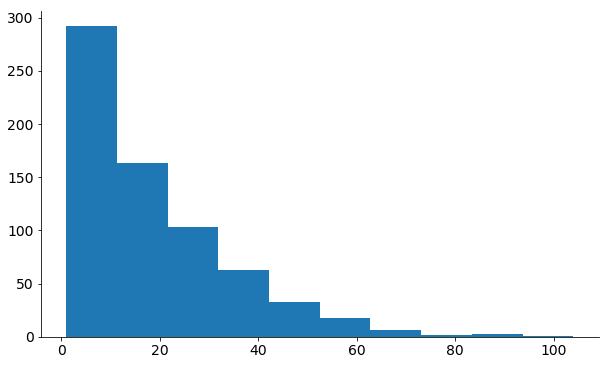

In [26]:
# drop respondents who have no missing
freq0_wo_zero = [v for v in freq0 if v>0]

# mean and median of missing months per respondent
print 'mean: %s, median: %s'%(np.mean(freq0_wo_zero), np.median(freq0_wo_zero))

# plot histogram
plt.hist(freq0_wo_zero)
remove_border()

### status 2 - working, with missing hours

In [27]:
freq2 = res_df.apply(lambda row: count_status_per_R(row, 2), axis=1)
print "%s respondents have no month working with missing hours"%sum([v==0 for v in freq2])

1369 respondents have no month working with missing hours


mean: 25.9965502372, median: 16.0


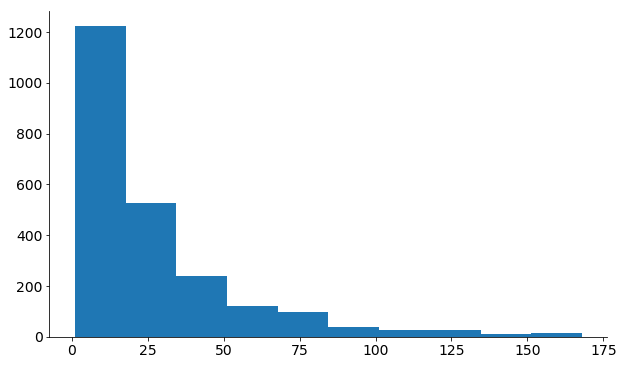

In [28]:
# drop respondents who have no month working with missing hours
freq2_wo_zero = [v for v in freq2 if v>0]

# mean and median of missing months per respondent
print 'mean: %s, median: %s'%(np.mean(freq2_wo_zero), np.median(freq2_wo_zero))

# plot histogram
plt.hist(freq2_wo_zero)
remove_border()